In [1]:
# import statements
import random
import torch
import seaborn
import pandas as pd
from tqdm import tnrange, tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import networkx as nx
import torch.nn.functional as F

from collections import namedtuple
from utils.data.load_graphs import load_graphs
from torch_geometric.loader import DataLoader
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.plotting.plot_events import plot_event

In [7]:
in_dir = 'data/graphs'
trained_model_dir = f'models/IN_trained_100_neurons_8.pt'
model = torch.load(trained_model_dir)
model.eval()

nevents = 1
node_dim = 3
edge_dim = 3

threshold = 0.5


graphs = load_graphs(in_dir, nevents, node_dim, edge_dim) 
test_data = GraphDataset(graphs)

In [ ]:
def split_event(data):
    ''' 
    Divide into 'before' (z<360cm), 'inside' (360cm<=z<500cm) and 'after' (z>500cm) the magnetic field
    '''
    ids1 = np.argwhere(data[:,-2]*100 < 360)
    ids2 = np.argwhere((data[:,-2]*100 >= 360) & (data[:,1]*100 < 500))
    ids3 = np.argwhere(data[:,-2]*100 >= 500)
    
    return [data[ids1].squeeze(), data[ids2].squeeze(), data[ids3].squeeze()]

In [60]:
def build_tracklets(model, data, thld):
    reco = []
    output = model(data).squeeze(1).detach().numpy()

    ids = np.unique(data.pid.T[1])
    evID = np.unique(data.pid[0])

    segments = data.edge_index.T
    p_t = np.hstack((segments, np.vstack(output)))
    p_t = p_t[p_t[:,2]>=thld]

    G = nx.Graph()
    G.add_weighted_edges_from(p_t)

    for g in nx.connected_components(G):
        item = np.array(list(g)).astype(np.int32)
        x = data.x[item].squeeze()
        x = np.concatenate((np.array([item]).T, x), axis=1)
        x = x[x[:, 2].argsort()]
        reco.append(x)
        
    return reco

In [85]:
tot_purity    = []
tot_coverage  = []
tot_partially = []
tot_fully     = []
tot_ghost     = []

min_track_len = 6


thlds = np.linspace(0.05, 0.95, 10)

for thld in thlds:
    
    # define the QA variables
    n_reconstructible = 0
    n_partiallyfound  = 0
    n_fullyfound      = 0
    n_ghost           = 0
    purity            = []
    mc_coverage       = []
    
    for data in test_data:
        reco = build_tracklets(model, data, thld)
            
        # calculate purity, MC coverage, n_reconstructible and n_reconstructed
        for pid in np.unique(data.pid[:,1]):
            
            tIDs = np.argwhere(data.pid[:,1] == pid)
            ttrack = data.x[tIDs].squeeze()
            ttrack = np.concatenate((tIDs.T, ttrack), axis=1)
            
            if len(tIDs[0]) >= min_track_len:
                n_reconstructible += 1                               

                for rtrack in reco:
                    if len(rtrack >= min_track_len):
                        pure  = len(np.intersect1d(ttrack[:,0], rtrack[:,0])) / len(rtrack)
                        cover  = len(np.intersect1d(ttrack[:,0], rtrack[:,0])) / len(ttrack)
                        
                        if pure > 0.8:
                            purity.append(pure)
                            mc_coverage.append(cover)
                            n_partiallyfound += 1
                            if cover == 1:
                                n_fullyfound += 1
                        elif pure > 0:
                            purity.append(pure)
                            mc_coverage.append(cover)
                            n_ghost += 1
                            
                            
    tot_purity.append(np.mean(purity))
    tot_coverage.append(np.mean(mc_coverage))
    tot_partially.append(n_partiallyfound / n_reconstructible)
    tot_fully.append(n_fullyfound / n_reconstructible)
    tot_ghost.append(n_ghost / n_reconstructible)

    

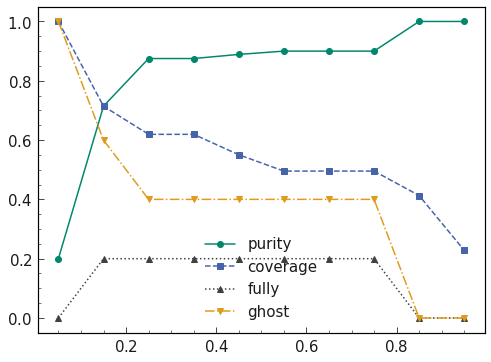

In [84]:
plt.plot(thlds, tot_purity, label = 'purity')
plt.plot(thlds, tot_coverage, label = 'coverage')
# plt.plot(thlds, tot_partially, label= 'partially')
plt.plot(thlds, tot_fully, label = 'fully')
plt.plot(thlds, tot_ghost, label = 'ghost')
plt.legend()

In [ ]:
plot_event(graph=graphs[0]).plot_traineddisplay(model, disc=0.5)
plot_event(graph=graphs[0]).plot_tracklet_display(reco)

In [ ]:
#         data = GraphDataset(self.graph)[0]
#         output = model(data)

#         evID = graph.pid.index.unique()[0]
#         X = np.array(data.x)
#         segments = data.edge_index.T
#         p_t = np.hstack((segments, np.vstack(output)))

In [ ]:
a.shape, b.T.shape